In [2]:
import torch

print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())
print(torch.cuda.get_device_capability())

2.0.1+cu118
True
NVIDIA GeForce GTX 1650
(7, 5)


In [3]:
"""
RuntimeError: Only Tensors of floating point and complex dtype can require gradients
"""
# a = torch.tensor(1, requires_grad=True)

# print(a)

'\nRuntimeError: Only Tensors of floating point and complex dtype can require gradients\n'

#### Pytorch计算图

Pytorch与Tensorflow不同，其使用动态计算图(dynamic computational graphs), 更易于调试。更准确来讲，其使用的是`有向无环图(directed acyclic graph, DAG)`.

如下是一个计算示例：

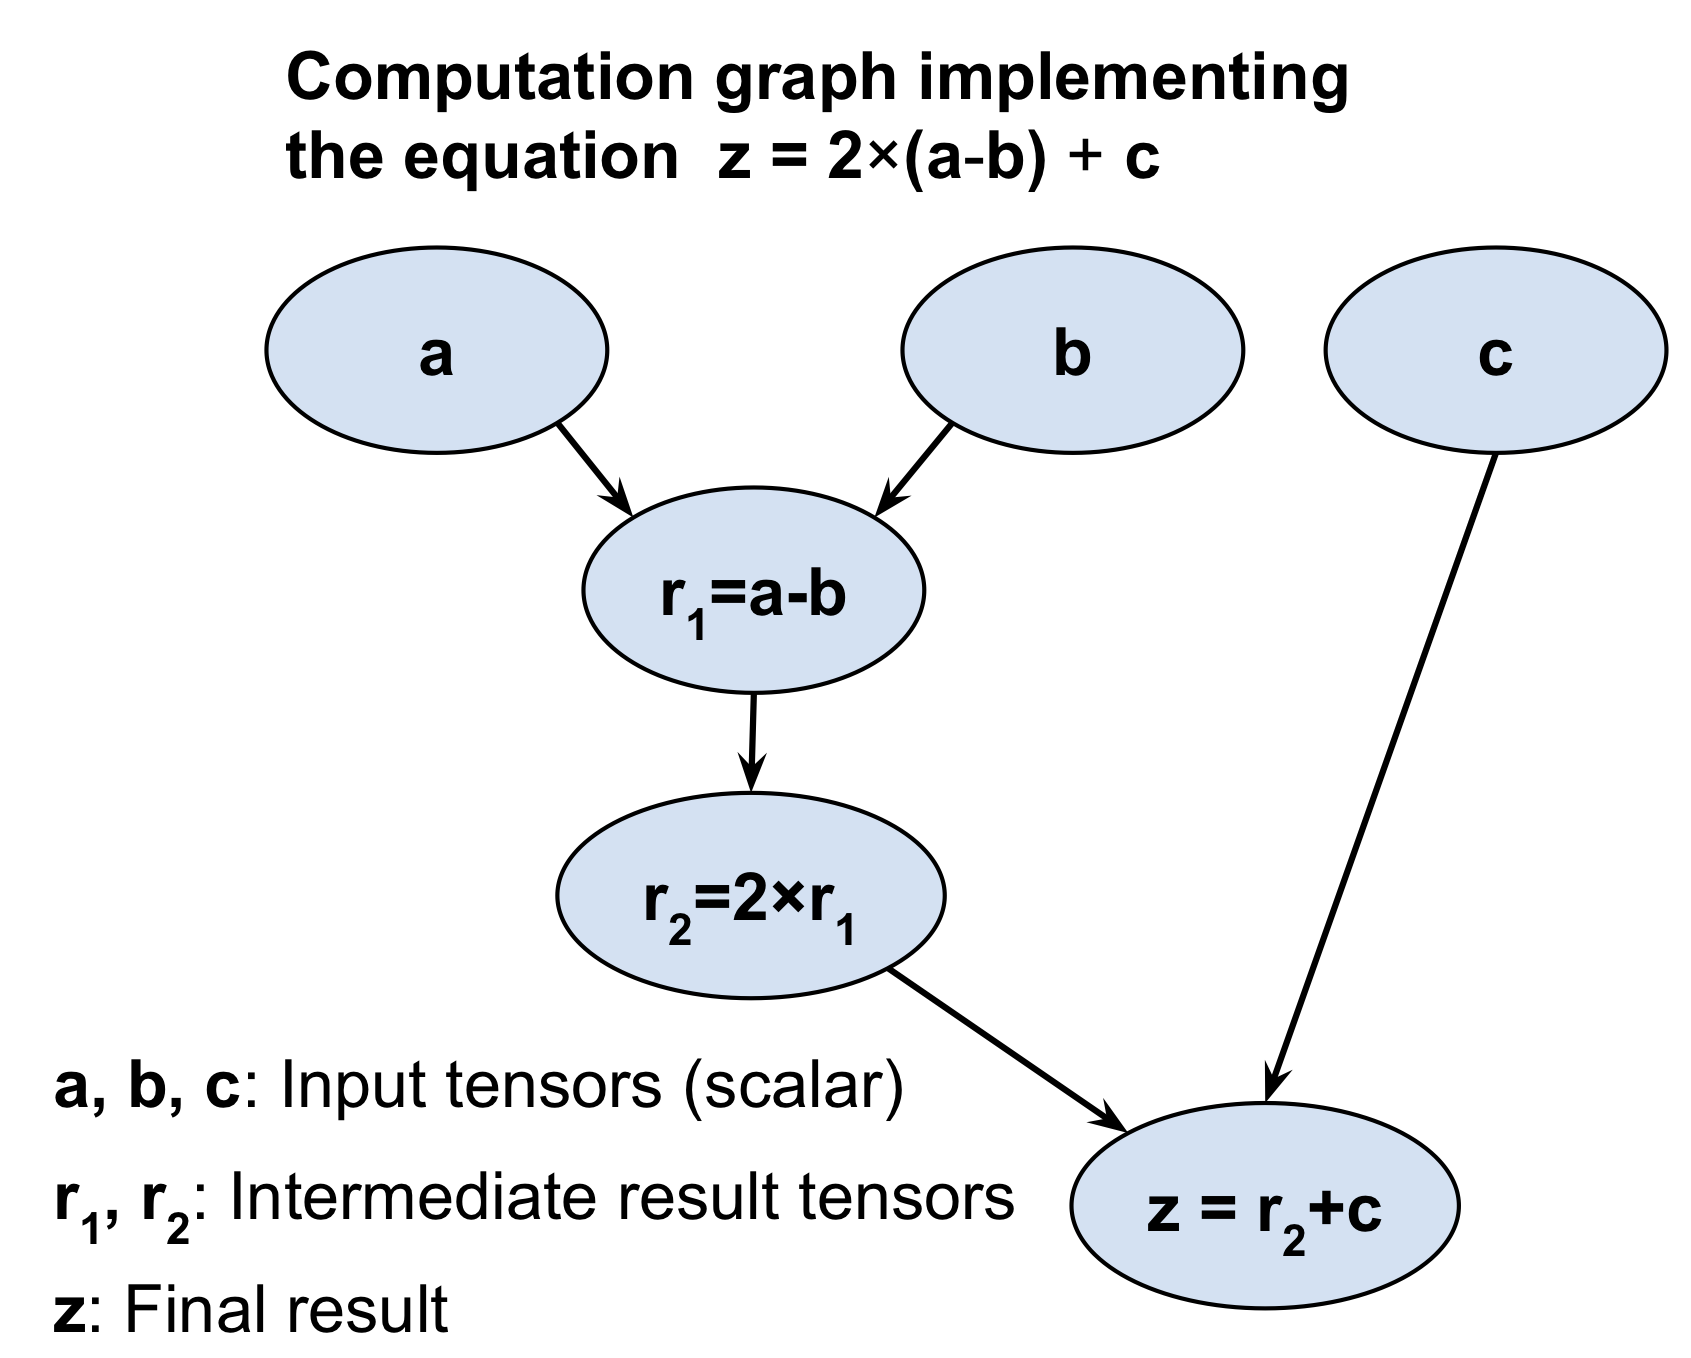

In [4]:
from IPython.display import Image

Image(filename='../Python-MachineLearning/Attached_images/Chapter13/figures/13_01.png', 
      width=450)

##### 利用Python创建一个计算图

In [5]:
import torch

def compute_z(a, b, c):
    r1 = torch.sub(a, b)
    r2 = torch.mul(r1, 2)
    z = torch.add(r2, c)
    return z

In [6]:
print('Scalar Inputs:', compute_z(torch.tensor(1), torch.tensor(2), 
                                  torch.tensor(3)))

Scalar Inputs: tensor(1)


In [7]:
print('Rank 1 Inputs:', compute_z(torch.tensor([1]), torch.tensor([2]), 
                                  torch.tensor([3])))

Rank 1 Inputs: tensor([1])


In [8]:
print('Rank 2 Inputs:', compute_z(torch.tensor([[1]]), torch.tensor([[2]]), 
                                  torch.tensor([[3]])))

Rank 2 Inputs: tensor([[1]])


#### 用于存储和更新模型参数的Pytorch张量对象

In [9]:
a = torch.tensor(3.14, requires_grad=True)
print(a)

tensor(3.1400, requires_grad=True)


In [10]:
b = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
print(b)

tensor([1., 2., 3.], requires_grad=True)


需要注意的是，requires_grad默认设置为False. 通过`requires_grad_()`可以设置为True.

method_()是Pytorch中的一种原地操作方法，无需复制输入.

示例如下：

In [11]:
# 原地操作，设置requires_grad=True.
w = torch.tensor([1.0, 2.0, 3.0])
print(w.requires_grad)

w.requires_grad_()
print(w)

False
tensor([1., 2., 3.], requires_grad=True)


#### 关于参数的随机初始化.

In [12]:
# 这里使用Glorot initialization.
import torch.nn as nn

torch.manual_seed(1)
w = torch.empty(2, 3)
nn.init.xavier_normal_(w)
print(w)

tensor([[ 0.4183,  0.1688,  0.0390],
        [ 0.3930, -0.2858, -0.1051]])


Glorot initialization是由Xavier Glorot和Yoshua Bengio等人提出的. `这种方法背后的思想是：粗略地平衡不同层之间的梯度方差， 否则某些层可能会在训练期间受到过多关注`.

根据这[两个人的论文](https://proceedings.mlr.press/v9/glorot10a)，如果我们需要以均匀分布初始化权重，我们应该选择如下分布：
$$W\sim Uniform\left(-\frac{\sqrt{6}}{\sqrt{n_{in}+n_{out}}},\frac{\sqrt{6}}{\sqrt{n_{in}+n_{out}}}\right)$$

其中，$n_{in}$是与权重相乘的输入神经元的数量，$n_{out}$是输入到下一层的输出神经元数量.为了从高斯分布初始化权重，建议采用的高斯分布标准差为：
$$\sigma=\frac{\sqrt{2}}{\sqrt{n_{in}+n_{out}}}$$

In [13]:
# 一个实现示例.
class MyMoudle(nn.Module):
    def __init__(self):
        super().__init__()
        self.w1 = torch.empty(2, 3, requires_grad=True)
        nn.init.xavier_normal_(self.w1)
        self.w2 = torch.empty(1, 2, requires_grad=True)
        nn.init.xavier_normal_(self.w2)

#### 通过自动微分计算梯度

优化神经网络需要计算损失函数相对于权重的梯度，这是优化算法(例如SGD)所必须的。此外，梯度还有其他应用：

`例如，题刻可以诊断NN模型为什么对测试示例做出特定预测`.

In [14]:
# 一个Python计算示例.
w = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(0.5, requires_grad=True)

x = torch.tensor([1.4])
y = torch.tensor([2.1])
z = torch.add(torch.mul(w, x), b)

loss = (y-z).pow(2).sum()
loss.backward()

print('dl/dw: ', w.grad)
print('dl/db: ', b.grad)

dl/dw:  tensor(-0.5600)
dl/db:  tensor(-0.4000)


In [15]:
# 对上述计算过程的一个验证.
print("manual calculate:", (2 * x *((w * x + b) - y)))

manual calculate: tensor([-0.5600], grad_fn=<MulBackward0>)


#### 通过torch.nn模块简化常见架构的实现

##### 基于nn.Sequential来实现模型

In [16]:
# 使用nn.Sequential, 则模型内部存储的层以级联方式连接, 一个示例如下：
model = nn.Sequential(nn.Linear(4, 16), 
                      nn.ReLU(),
                      nn.Linear(16, 32), 
                      nn.ReLU())

model

Sequential(
  (0): Linear(in_features=4, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ReLU()
)

In [17]:
# 对上述定义的两个线性层进行配置.
nn.init.xavier_normal_(model[0].weight)
l1_weight = 0.01
l1_penalty = l1_weight * model[2].weight.abs().sum()

在上述代码中，对第一个Linear层的权重使用了Xavier初始化, 对第二个Linear层使用了L1正则化，且权重系数为0.01.

进一步为模型指定优化器和损失函数.

##### 选择一个损失函数

In [18]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

#### 解决XOR分类问题

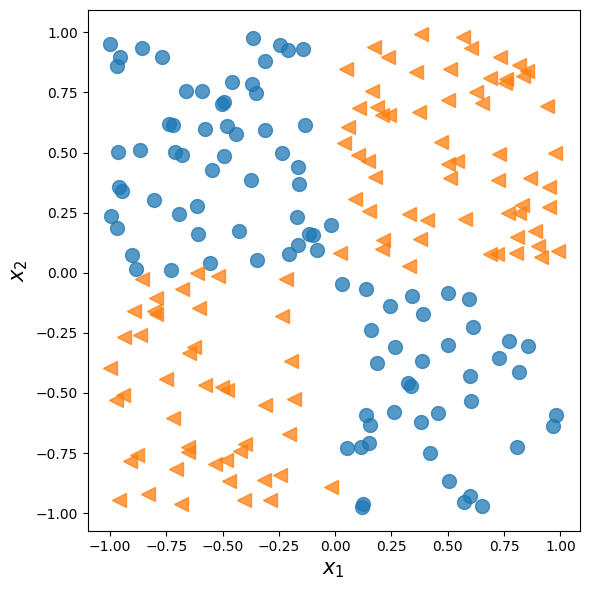

In [21]:
# 生成一个示例数据.
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


np.random.seed(1)
torch.manual_seed(1)
x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x))
y[x[:, 0] * x[:, 1]<0] = 0

n_train = 100
x_train = torch.tensor(x[:n_train, :], dtype=torch.float32)
y_train = torch.tensor(y[:n_train], dtype=torch.float32)
x_valid = torch.tensor(x[n_train:, :], dtype=torch.float32)
y_valid = torch.tensor(y[n_train:], dtype=torch.float32)

fig = plt.figure(figsize=(6, 6))
plt.plot(x[y==0, 0], 
         x[y==0, 1], 'o', alpha=0.75, markersize=10)
plt.plot(x[y==1, 0], 
         x[y==1, 1], '<', alpha=0.75, markersize=10)
plt.xlabel(r'$x_1$', size=15)
plt.ylabel(r'$x_2$', size=15)
plt.tight_layout()
plt.savefig('../Python-MachineLearning/Attached_images/Chapter13/figures/13_02.png', 
            dpi=600)
plt.show()